<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# CNN Example with TensorBoard
In this demo notebook we are going to demonstrate the use of [TensorBoard](https://www.tensorflow.org/tensorboard/) with PyTorch to track and visualize metrics during model training, which is useful to evaluate model performance and compare models across experimentations.  Although TensorBoard was originally developed for use with TensorFlow, it is also supported within PyTorch.

In [ ]:
# Run this cell only if working in Colab
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "AIPI540-Deep-Learning-Applications" # Enter repo name
git_path = 'https://github.com/AIPI540/AIPI540-Deep-Learning-Applications.git'
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}"

# Change working directory to location of notebook
notebook_dir = 'computer_vision/CNNs'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

In [1]:
import os
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchsummary import summary
import urllib.request
import zipfile

TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

%load_ext tensorboard

torch:  1.10 ; cuda:  1.10.0


In [3]:
# Download the data
if not os.path.exists('./data'):
    os.mkdir('./data')
if not os.path.exists('data/hymenoptera_data'):
    url = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'
    urllib.request.urlretrieve(url,filename='data/hymenoptera_data.zip')
    zip_ref = zipfile.ZipFile('data/hymenoptera_data.zip', 'r')
    zip_ref.extractall('data/')
    zip_ref.close()

In [4]:
data_dir = 'data/hymenoptera_data'

# Set up transformations for training and validation (test) data
# For training data we will do randomized cropping to get to 224 * 224, randomized horizontal flipping, and normalization
# For test set we will do only center cropping to get to 224 * 224 and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create Datasets for training and validation sets
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                          data_transforms['train'])
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'),
                                          data_transforms['val'])

# Create DataLoaders for training and validation sets
batch_size = 4
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                             shuffle=False, num_workers=4)

# Set up dict for dataloaders
dataloaders = {'train':train_loader,'val':val_loader}
# Store size of training and validation sets
dataset_sizes = {'train':len(train_dataset),'val':len(val_dataset)}
# Get class names associated with labels
class_names = train_dataset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

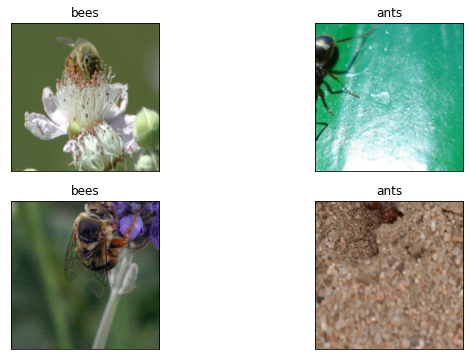

In [5]:
images, labels = iter(train_loader).next()
images = images.numpy()
fig = plt.figure(figsize=(10, 6))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size//2, idx+1, xticks=[], yticks=[])
    image = images[idx]
    image = image.transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    ax.set_title("{}".format(class_names[labels[idx]]))

### Define our neural network architecture

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of the network in the function `forward`, which takes in an input image tensor, `x`.  We will create a CNN with two convolutional layers, each followed by a ReLu activation function and then a pooling layer using MaxPool.  For each of our convolutional layers we will use a 3x3 kernel with stride=1 and padding=1 in order to maintain the input shape as it passes through the layer.

In [6]:
class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()
        
        # Convolutional 1 layer: 3x3 kernel, stride=1, padding=1, 10 output channels / feature maps
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1)
        # Conv1 layer output size = (W-F+2P)/S+1 = (224-3+2)/1+1 = 224
        # Conv1 layer output shape for one image: (10,222,222)
        
        # maxpool layer
        # pool with kernel_size=2, stride=2
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Pool output shape for one image: (10,112,112)
        
        # Convolutional 2 layer: 3x3 kernel, stride=1, padding=1, 20 output channels / feature maps
        self.conv2 = nn.Conv2d(in_channels=10,out_channels=10,kernel_size=3, stride=1, padding=1)
        # Conv2 layer output size = (W-F+2P)/S+1 = (112-3+2)/1+1 = 112
        # Conv2 layer output shape for one image: (10,112,112)
        
        # maxpool layer
        # pool with kernel_size=2, stride=2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Pool output shape for one image: (10,56,56)
        
        # Input size: 10 * 56 * 56 = 31360 from pool2 pooling layer
        # 2 output channels (for the 2 classes)
        self.fc1 = nn.Linear(10*56*56, 2)
        
    def forward(self, x):
        # Two convolutional layers followed by relu and then pooling
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))

        # Flatten into a vector to feed into linear layer
        x = x.view(x.size(0), -1)
        
        # Linear layer
        x = self.fc1(x)
        
        return x

### Define a cost / loss function and optimizer

In [7]:
# Instantiate the model
net = ConvNet()

# Display a summary of the layers of the model and output shape after each layer
summary(net,(images.shape[1:]),batch_size=batch_size)

# Cross entropy loss combines softmax and nn.NLLLoss() in one single class.
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.SGD(net.parameters(),  lr=0.001, momentum=0.9)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [4, 10, 224, 224]             280
         MaxPool2d-2          [4, 10, 112, 112]               0
            Conv2d-3          [4, 10, 112, 112]             910
         MaxPool2d-4            [4, 10, 56, 56]               0
            Linear-5                     [4, 2]          62,722
Total params: 63,912
Trainable params: 63,912
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 2.30
Forward/backward pass size (MB): 23.93
Params size (MB): 0.24
Estimated Total Size (MB): 26.47
----------------------------------------------------------------


### Train the model
To train our model, we perform the following four steps in a loop, using one input mini-batch at a time:  
    1) Make a forward pass through the network to calculate the network output  
    2) Use the network output to calculate the cost/loss  
    3) Calculate the gradient of the cost with respect to the weights by performing a backward pass through the network with `loss.backward()`  
    4) Update the weights by taking a step with the optimizer

If GPU is available, we can move the model (all its parameter Tensors) onto GPU. If we decided to use GPU, we also need to put all the data Tensors used in training onto GPU.

In [ ]:
def train_model(model, criterion, optimizer, dataloaders, device, num_epochs=25):

    model = model.to(device) # Send model to GPU if available

    writer = SummaryWriter() # Instantiate TensorBoard

    iter_num = {'train':0,'val':0} # Track total number of iterations

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Get the input images and labels, and send to GPU if available
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the weight gradients
                optimizer.zero_grad()

                # Forward pass to get outputs and calculate loss
                # Track gradient only for training data
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backpropagation to get the gradients with respect to each weight
                    # Only if in train
                    if phase == 'train':
                        loss.backward()
                        # Update the weights
                        optimizer.step()

                # Convert loss into a scalar and add it to running_loss
                running_loss += loss.item() * inputs.size(0)
                # Track number of correct predictions
                running_corrects += torch.sum(preds == labels.data)

                # Iterate count of iterations
                iter_num[phase] += 1

                # Write loss for batch to TensorBoard
                writer.add_scalar("{} / batch loss".format(phase), loss.item(), iter_num[phase])

            # Calculate and display average loss and accuracy for the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Write loss and accuracy for epoch to TensorBoard
            writer.add_scalar("{} / epoch loss".format(phase), epoch_loss, epoch)
            writer.add_scalar("{} / epoch accuracy".format(phase), epoch_acc, epoch)

    writer.close()
    
    return

In [ ]:
# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_model(net, criterion, optimizer, dataloaders, device, num_epochs=30)

In [ ]:
# Launch TensorBoard to visualize model performance during training cycle
%tensorboard  --logdir=runs

We can also add additional models to the TensorBoard to compare their performance over the training cycle.  For example, below we will use a different learning rate and then we can compare the results on the TensorBoard.

In [ ]:
# Select a different optimizer to compare
net = ConvNet()
optimizer = optim.SGD(net.parameters(), lr=0.1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_model(net, criterion, optimizer, dataloaders, device, num_epochs=30)

In [ ]:
# Launch TensorBoard to visualize model performance during training cycle
%tensorboard  --logdir=runs

## Visualize results

In [ ]:
# Display a batch of predictions

def visualize_results(model,dataloader,device):
    model = model.to(device) # Send model to GPU if available
    with torch.no_grad():
        model.eval()
        # Get a batch of validation images
        images, labels = iter(val_loader).next()
        images, labels = images.to(device), labels.to(device)
        # Get predictions
        _,preds = torch.max(model(images), 1)
        preds = np.squeeze(preds.cpu().numpy())
        images = images.cpu().numpy()

    # Plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(15, 10))
    for idx in np.arange(len(preds)):
        ax = fig.add_subplot(2, len(preds)//2, idx+1, xticks=[], yticks=[])
        image = images[idx]
        image = image.transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        ax.imshow(image)
        ax.set_title("{} ({})".format(class_names[preds[idx]], class_names[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx] else "red"))
    return

visualize_results(net,val_loader,device)